In [1]:
%matplotlib inline
from PIL import Image
import numpy
import os
import re
import random
from resizeimage import resizeimage
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.decomposition import PCA
import copy
import matplotlib.image as mpimg
from sklearn.decomposition import RandomizedPCA

In [2]:
# resize images
# resizeImages('../data/yalefaces/', 'subject01')
def resizeImagesToDest(source, dest, prefix, height, noiseAlgo=None):    
    for root, dirs, files in os.walk(source):
        for name in files:
            if re.match(r'^'+prefix+'.*gif$', name, re.I):
                img = Image.open(os.path.join(source, name))
                (origWidth, origHeight) = img.size
                if (height == origHeight):
                    resizedImg = img
                else:
                    resizedImg = resizeimage.resize_height(img, height)
                    
                (width, height) = resizedImg.size
                if noiseAlgo:
                    noisyImg = noiseAlgo(numpy.asarray(resizedImg))
                    Image.fromarray(numpy.uint8(noisyImg.reshape(height,width))).save(dest+name)
                else:
                    resizedImg.save(dest+name)

def resizeImages(source, prefix):
    resizeImageToDest(source, 'yalefaces_resized/', prefix, 50)
                
# images into array: http://stackoverflow.com/questions/13550376/pil-image-to-array-numpy-array-to-array-python
def readImagesIntoMatrix(path, prefix):
    images = None
    for root, dirs, files in os.walk(path):
        for name in files:
            if re.match(r'^'+prefix+'.*gif$', name, re.I):
                img = Image.open(path + name)                
                (width, height) = img.size
                imgArr = numpy.asarray(img).reshape(height * width)
                if images is not None:
                    images = numpy.vstack([images, imgArr])
                else:
                    images = imgArr
    return images

def saveImages(path, images, width, height):
    for i in range(0, len(images)):
        Image.fromarray(numpy.uint8(images[i]).reshape(height, width)).save(path+str(i)+'.gif')
        
def addGaussianNoise(image):
    noisyImage = copy.deepcopy(image)
    mu = noisyImage.mean()
    std = noisyImage.std()
    noise = 0.2 * numpy.random.normal(mu, std, noisyImage.shape)
    for i in range(len(image)):
        for j in range(len(image[0])):
            val = image[i][j]
            if val + noise[i][j] >= 255:
                noisyImage[i][j] = 255
            elif val + noise[i][j] <= 0:
                noisyImage[i][j] = 0
            else:
                noisyImage[i][j] = val + noise[i][j] 
    
    return noisyImage  
    
def addSparseNoise(image):
    noisyImage = copy.deepcopy(image)
    for i in range(len(image)):
        for j in range(len(image[0])):
            rand = random.random()
            if (rand <= 0.01):
                noisyImage[i][j] = 0
    
    return noisyImage

In [22]:
#resizeImages('yalefaces/', 'subject.*')
imageList = readImagesIntoMatrix('yalefaces_resized/', 'subject.*happy').T

#Image.fromarray(numpy.uint8(imageList.T[0].reshape(50,66))).save("test/testsaveimage1.gif")

In [23]:
(width, height) = 66, 50
# average Image
avgImg =  numpy.mean(imageList, axis=1)
#Image.fromarray(numpy.uint8(avgImg.reshape(50,66))).save('test/avgImg.gif')

In [24]:
# Subtract mean from each column (which are rows of transpose, how numpy does it)
imagesDiff = (imageList.T - avgImg).T

# Get EigenVectors
covMatrix = numpy.cov(imagesDiff, rowvar=True)
eigenVal, eigenVec = numpy.linalg.eigh(covMatrix)

# Sort eigenvectors
# http://stackoverflow.com/questions/8092920/sort-eigenvalues-and-associated-eigenvectors-after-using-numpy-linalg-eig-in-pyt
idx = eigenVal.argsort()[::-1]
eigenVal = eigenVal[idx]
eigenVec = eigenVec[:,idx]

In [25]:
# Testing the eigenvectors
# Taken from http://sebastianraschka.com/Articles/2014_pca_step_by_step.html
for i in range(len(eigenVal)):
    eigv = eigenVec[:,i].reshape(1,3300).T
    numpy.testing.assert_array_almost_equal(covMatrix.dot(eigv), eigenVal[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)

# Also lets assert the eigenvectors are orthogonal
for i in range(len(eigenVal)):
    for j in range(len(eigenVal)):
        if i < j:
            break # Comment this out if you want to run this silly test
            # Commented out because if you run this it takes FOREVER.
            # numpy.testing.assert_almost_equal(0, eigenVec[i].T.dot(eigenVec[j]))

In [26]:
def normalize_face(vector):
    minValue = numpy.amin(vector)
    maxValue = numpy.amax(vector)
    scale = (255./(maxValue-minValue))
    return (vector - minValue)*scale

for i in range (1, 100):
    eigv = eigenVec[:,i].reshape(1,3300).T
    eigenface = normalize_face(eigv)
    #Image.fromarray(numpy.uint8(eigenface.reshape(50,66))).save('test/happy_eigenface%s.gif' % i)

In [39]:
def top_k_eigenface(image, eigenVectors, k):
    start_vector = numpy.zeros((50*66))
    for i in range(0, k-1):
        eigv = eigenVec[:,i].reshape(3300)
        weight = numpy.inner(image, eigv)
        start_vector = start_vector + weight * eigv
    return start_vector

numComponents = 15
projections = []
for i in range(0, len(imagesDiff.T)):
    projection = top_k_eigenface(imagesDiff.T[i].reshape(3300), eigv, numComponents)+avgImg
    projections.append(projection)
    #print ('Projection dimensions %s' % (projection.shape,))
    #Image.fromarray(numpy.uint8(projection.reshape(50,66))).save('test/happy_13_projection_of_subject%s.gif' % i)
    projection = top_k_eigenface(imagesDiff.T[i].reshape(3300), eigv, 3300)+avgImg
    #Image.fromarray(numpy.uint8(projection.reshape(50,66))).save('test/happy_3300_projection_of_subject%s.gif' % i)

In [3]:
## Metrics Builder
class MetricsBuilder():

    def __init__(self, imagePath, label, algo=PCA):
        self.imageList = []
        self.imagePath = imagePath
        self.nComponents = 0
        self.imgWidth = 0
        self.imgHeight = 0
        self.imgDepth = 0
        self.label = label
        self.pca = algo
    
    def readImagesIntoMatrix(self, path):
        images = None
        for root, dirs, files in os.walk(path):
            for name in files:
                if re.match(r'.*gif$', name, re.I):
                    #img = Image.open(path + name)
                    img = mpimg.imread(path+ name)
                    (self.imgHeight, self.imgWidth, self.imgDepth) = img.shape
                    imgArr = numpy.asarray(img).reshape(self.imgHeight * self.imgWidth * self.imgDepth)
                    if images is not None:
                        images = numpy.vstack([images, imgArr])
                    else:
                        images = imgArr
        return images  
        
    def plotImages(self, images, label):
        fig = plt.figure(figsize=(6,3)) 
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
        fig.suptitle(label + ' (' + self.label + ')', y=1.1, fontsize=16)

        for i in range(len(images)):
            ax = fig.add_subplot(3, 5, i+1, xticks=[], yticks=[])
            ax.imshow(images[i].reshape(self.imgHeight, self.imgWidth, self.imgDepth), cmap=plt.cm.bone, interpolation='nearest')
    
    def plotExplainedVariance(self, ratios):
        numComponents = self.nComponents
        curSum = 0
        cumData = []
        for idx, val in enumerate(ratios):
            curSum = curSum + val
            cumData.append(curSum)

        fig = plt.figure(figsize=(15,4))
        ax = fig.add_subplot(121)
        ax.plot(range(1, numComponents+1), cumData);
        ax.set_title('Cummulative Variance Explained by ' + str(numComponents) + ' Principal Components')
        ax.set_xlabel('Principal Components')
        ax.set_ylabel('% Variance Explained')
        ax.set_ylim([0., 1.0])
        plt.xticks(range(1, numComponents+1))

        # add line to indicate 90% variance line
        plt.plot([1, numComponents], [0.9, 0.9], 'k:', lw=2)

        plt.margins(x=0)

        ax = fig.add_subplot(122)
        ax.plot(range(1, numComponents+1), ratios);
        ax.set_title('Variance Explained by each ' + str(numComponents) + ' Principal Components')
        ax.set_xlabel('Principal Components')
        ax.set_ylabel('% Variance Explained')
        ax.set_ylim([0., 1.0])
        plt.xticks(range(1, numComponents+1))
        plt.margins(x=0)        
    
    def saveReconstructedImages(self, dest):
        for idx, img in enumerate(self.inverseTransformedImageList):
             Image.fromarray(numpy.uint8(img).reshape(self.imgHeight, self.imgWidth, self.imgDepth)).save(dest+'img_'+str(idx)+'.gif')
    
    def build(self):
        self.imageList = self.readImagesIntoMatrix(self.imagePath)

        pca = self.pca
        self.reducedImageList = pca.fit_transform(self.imageList)
        self.inverseTransformedImageList = pca.inverse_transform(self.reducedImageList)
        self.nComponents = len(pca.components_)
        self.plotImages(self.imageList, 'Original Images')
        self.plotImages(self.inverseTransformedImageList, 'Rec Images')
        self.plotExplainedVariance(pca.explained_variance_ratio_)

In [57]:
#resizeImagesToDest('yalefaces/', 'train/normal/', '^subject01.+', 243)
#resizeImagesToDest('yalefaces/', 'train/oneoff/', 'subject01', 243)
#resizeImagesToDest('yalefaces/', 'train/gaussian_noise/', 'subject01', 243, addGaussianNoise)
#resizeImagesToDest('yalefaces/', 'train/sparse_noise/', 'subject01', 243, addSparseNoise)
resizeImagesToDest('scene/', 'train/scene/', '.*', 133)

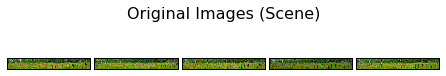

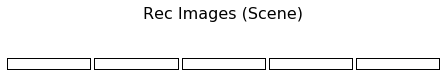

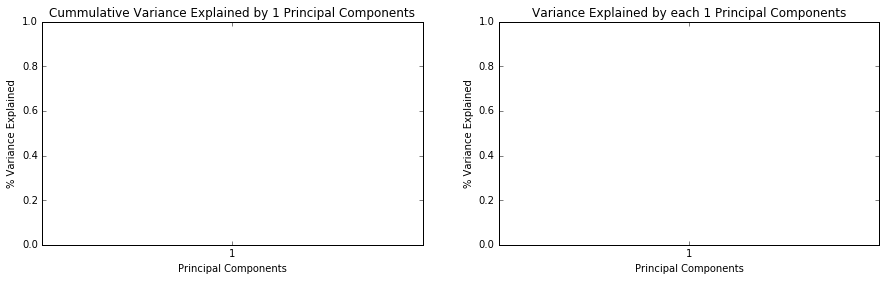

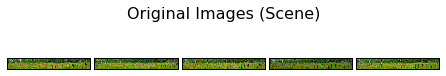

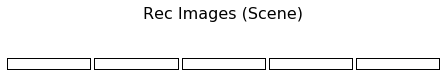

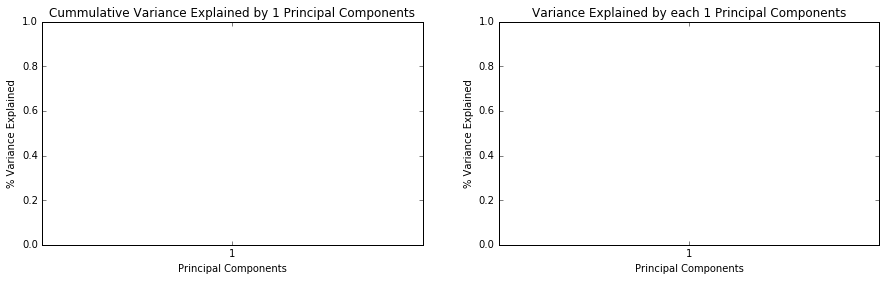

In [7]:
# metrics = MetricsBuilder('train/normal/', 'Normal', algo=PCA(n_components=2))
# metrics.build()

# metrics = MetricsBuilder('train/oneoff/', 'One Off', algo=PCA(n_components=2))
# metrics.build()

# metrics = MetricsBuilder('train/gaussian_noise/', 'Gaussian Noise', algo=PCA(n_components=2))
# metrics.build()

# metrics = MetricsBuilder('train/sparse_noise/', 'Sparse Noise', algo=PCA(n_components=2))
# metrics.build()

# # reconstruct with 1 component and see how much background noise is removed
metrics = MetricsBuilder('train/scene/', 'Scene', algo=PCA(n_components=1, svd_solver='full'))
metrics.build()
metrics.saveReconstructedImages('train/scene_rec/')

metrics = MetricsBuilder('train/scene/', 'Scene', algo=PCA(n_components=1, svd_solver='randomized'))
metrics.build()
metrics.saveReconstructedImages('train/scene_rec_rand/')